In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
from datetime import datetime, date
from matplotlib import colors

In [2]:
counts = [1000, 2000, 3000, 5000, 10000, 25000, 50000, 100000, 150000, 250000]

## Compute things

In [3]:
indata = pickle.load(open("./massive_data/2026-01-20-reference.pkl", "rb"))
data_const_fb = indata["data"]
sc_cubes = pickle.load(open("./data/2026-01-16-mdwarf_mbins_3plx_turnover.pkl", "rb"))

In [4]:
synthdata = np.array(data_const_fb)
soltypes = np.zeros(len(synthdata), dtype=np.int8)
for i in range(len(soltypes)):
    soltypes[i] = synthdata[i]["solution_type"] 
    
rates = [len(soltypes[soltypes == soltype])/len(synthdata)*100 for soltype in [0,5,7,9,12]]
grid = [
    rates,
    [int(grp/100*len(synthdata)) for grp in rates]
]
row_labels = ["Rate (%)", "Counts"]
col_labels = ["low RUWE", "high RUWE", "Acceleration", "Jerk", "Full Orbit"]
pd.DataFrame(grid, index=row_labels, columns=col_labels)

,low RUWE,high RUWE,Acceleration,Jerk,Full Orbit
Rate (%),95.1852,3.7896,0.6612,0.1496,0.2144
Counts,237963.0000,9474.0000,1653.0000,374.0000,536.0000


In [34]:
indices = [0,5,7,9,12]
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type", "is_binary"]
masses = np.array([row["mass"] for row in data_const_fb])
percs = np.percentile(masses, np.arange(0, 110, 10))
for row in tqdm(data_const_fb):
    keep = True
    if row["is_binary"]:
        if row["period"] > 1e5: # cut at 1e4
            keep = False
    if keep:
        df = dict()
        df["soltype_index"] = indices.index(row["solution_type"])   
        df["mass_index"] = np.minimum(np.digitize(row["mass"], percs) - 1, 9)
        for item in relevant_list:
            df[item] = float(row[item])
    working_catalogue.append(df)
working_catalogue = np.array(working_catalogue)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [35]:
fit_fb = len(working_catalogue[::20][[w["is_binary"]==1 for w in working_catalogue[::20]]])/len(working_catalogue[::20])
fit_fb

0.25456

In [36]:
small_catalogue = working_catalogue[::20]
model_cube = Sampler.create_model_cube((35,25), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes, small_catalogue, model_cube=model_cube)
grids = synthsampler.assign_grids(small_catalogue, p_range=(1,8), q_range=(0.05,0.5), mass_binned=True, scale=3)

  0%|          | 0/12500 [00:00<?, ?it/s]

In [37]:
synthsampler.constrain_parameters(p_model=(4,1.3), step_count=1000, nwalkers=6,
                                 p_range=(1,8), q_range=(0.05,0.5), cutoff=np.exp(-18), 
                                grids=grids, catalogue=small_catalogue, model_cube=model_cube, mass_binned=True, scale=3, verbose=True)

Reducing catalogue...
Running markov chains...


100%|██████████| 1000/1000 [30:50<00:00,  1.85s/it]

Complete!


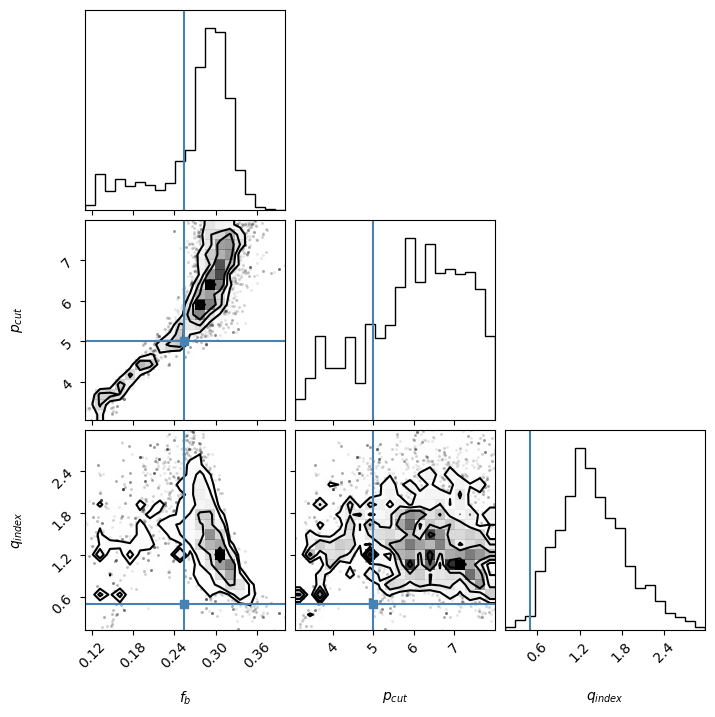

In [45]:
import corner
discard = 250
chain = synthsampler.sampler.get_chain(discard=discard, flat=True)
likelihoods = synthsampler.sampler.get_log_prob(discard=discard, flat=True) 
corner.corner(chain, weights=np.exp(likelihoods - np.max(likelihoods)),
              labels=["$f_b$", "$p_{cut}$", "$q_{index}$"],
              truths=[fit_fb, 5, 0.5]);

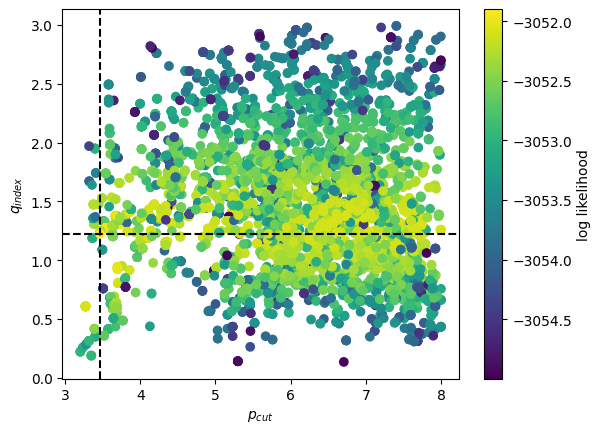

In [49]:
fig, ax = plt.subplots(1,1)

check_indices = [1,2]
param_names = ["$f_b$", "$p_{cut}$", "$q_{index}$"]

likelihood_cutoff = -3055
new_chain = chain[likelihoods > likelihood_cutoff]
new_likelihoods = likelihoods[likelihoods > likelihood_cutoff]

cb = ax.scatter(new_chain[:,check_indices[0]], new_chain[:,check_indices[1]], c=new_likelihoods, cmap='viridis', norm=colors.Normalize())
plt.colorbar(cb, label="log likelihood")
ax.set_xlabel(param_names[check_indices[0]]);
ax.set_ylabel(param_names[check_indices[1]]);
max_x, max_y = new_chain[:,check_indices[0]][np.argmax(new_likelihoods)], new_chain[:,check_indices[1]][np.argmax(new_likelihoods)]
ax.axvline(max_x, c="k", linestyle="--", label="highest likelihood");
ax.axhline(max_y, c="k", linestyle="--");

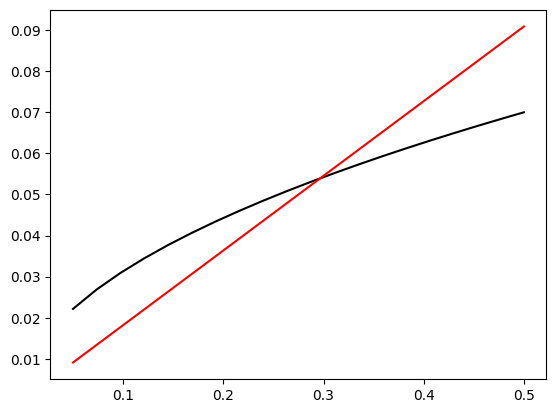

In [59]:
qs = np.linspace(0.05, 0.5, 20)
p5 = Sampler.pexp(qs, 0.5, val_range=(0.05,0.5), ignore_a=True)
p1 = Sampler.pexp(qs, 1, val_range=(0.05,0.5), ignore_a=True)
plt.plot(qs, p5/np.sum(p5), c="k");
plt.plot(qs, p1/np.sum(p1), c="r");

In [6]:
model_cube = Sampler.create_model_cube((25,25), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes, working_catalogue, model_cube=model_cube)
grids = synthsampler.assign_grids(working_catalogue, p_range=(1,8), q_range=(0.05,0.5), mass_binned=True, scale=3)

  0%|          | 0/250000 [00:00<?, ?it/s]

In [7]:
SAMPLE_COUNTS = 5
res = np.zeros((len(counts), SAMPLE_COUNTS, 3))

pbar = tqdm(total=len(counts))
for i, count in enumerate(counts):
    #temp_res = np.zeros((5,3))
    for j in range(SAMPLE_COUNTS):
        indices = np.random.choice(np.arange(len(working_catalogue)), count)   
        synthdata = working_catalogue[indices]
        working_grids = grids[indices]
        
        synthsampler = Sampler.popsampler(sc_cubes, synthdata, model_cube=model_cube)
        synthsampler.binarity(resolution=1000, grids=working_grids, catalogue=synthdata, scale=2, verbose=False)
        res[i,j] = synthsampler.fb_estimator()
    #res[i] = np.mean(np.array(temp_res), axis=0)
    pbar.update(1)

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.13 increased object counts testing"
outdata["data"] = dict()
outdata["data"] = res

outfile = open(f'./plot_data/counts_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

## Make plot

In [3]:
res = pickle.load(open("./plot_data/counts_test.pkl", "rb"))["data"]

In [10]:
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]
data_exp = np.array(data_exp)
bins = len(data_exp[[r["is_binary"] == True for r in data_exp]])
print(f'{bins/len(data_exp)*100:.2f}')

30.00


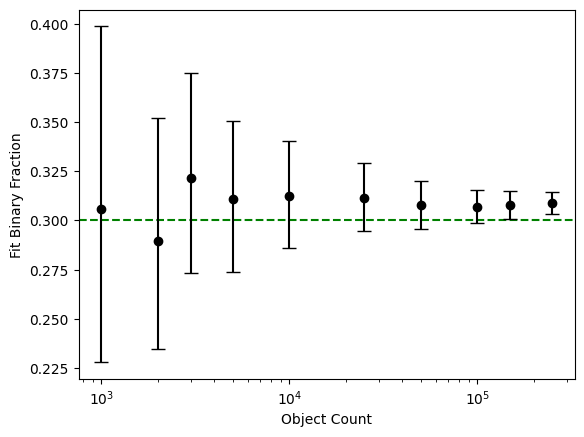

In [4]:
meaned_res = np.mean(np.array(res), axis=1)
plt.errorbar(counts, meaned_res[:,0], yerr=(meaned_res[:,2], meaned_res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(counts, meaned_res[:,0], marker='o', color='k', zorder=2);
plt.axhline(y=0.3, c="green", linestyle="--", zorder=0);
plt.xlabel("Object Count");
plt.ylabel("Fit Binary Fraction");
plt.xscale('log')

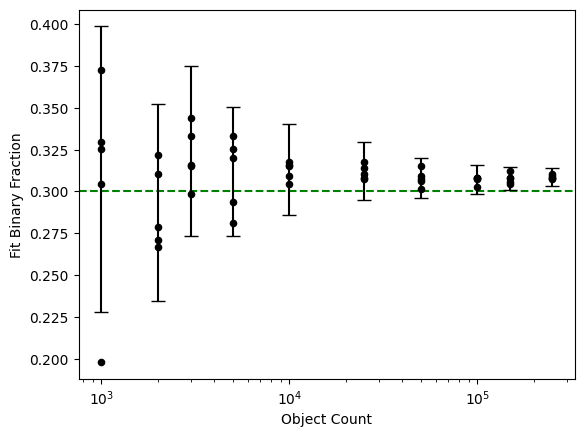

In [ ]:
for i in range(5):
    plt.scatter(counts, res[:,i,0], marker='o', color='k', s=20, zorder=2);
plt.errorbar(counts, meaned_res[:,0], yerr=(meaned_res[:,2], meaned_res[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.axhline(y=0.3, c="green", linestyle="--", zorder=0);
plt.xlabel("Object Count");
plt.ylabel("Fit Binary Fraction");
plt.xscale('log')
plt.savefig("./plots/2026-01-13-counts_test.png", dpi=800)